In [23]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, BatchNormalization, Flatten
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from tensorflow.keras.regularizers import l2

In [24]:
# Load all the processed datasets
file_paths = {
"medications": "Noisy/noisy_medications.csv",
"observations": "Noisy/noisy_observations.csv",
"patients": "ProcessedData/processed_patients.csv",
"allergies": "Noisy/noisy_allergies.csv",
"conditions": "Noisy/noisy_conditions.csv",
"immunizations": "Noisy/noisy_immunizations.csv",
}

In [25]:

def load_and_merge_data(file_paths):
    # Read and standardize identifier columns to "id"
    data_frames = {}
    for key, path in file_paths.items():
        df = pd.read_csv(path)
        id_columns = [col for col in df.columns if "PATIENT" in col or "Id" in col or "id" in col]
        if id_columns:
            df.rename(columns={id_columns[0]: "id"}, inplace=True)
        # Add source-specific suffixes to columns (except "id")
        df.columns = [f"{col}_{key}" if col != "id" else "id" for col in df.columns]
        data_frames[key] = df

    # Print initial row counts
    for key, df in data_frames.items():
        print(f"Rows in {key}: {len(df)}")

    # Merge all dataframes on the 'id' column
    merged_data = data_frames["patients"]
    for key, df in data_frames.items():
        if key != "patients":
            merged_data = pd.merge(merged_data, df, on="id", how="left")

    # Print final row count
    print(f"Rows in final merged dataset: {len(merged_data)}")

    # Remove unnecessary columns used for label creation
    columns_to_remove = [
        'REASONDESCRIPTION_COVID-19_medications',
        'Infectious disease care plan (record artifact)_careplans',
        'Body temperature_observations',
        'Oxygen saturation in Arterial blood_observations',
        'Suspected COVID-19_conditions',
        'Cause of Death [US Standard Certificate of Death]_observations'
    ]
    columns_in_data = [col for col in columns_to_remove if col in merged_data.columns]
    if columns_in_data:
        merged_data.drop(columns=columns_in_data, inplace=True)
        print(f"Removed columns: {columns_in_data}")

    print(merged_data.columns.tolist())
    return merged_data

def preprocess_data(data):
    # Fill missing values
    data.fillna(0, inplace=True)

    # Normalize numerical columns
    numerical_cols = data.select_dtypes(include=[np.number]).columns
    scaler = StandardScaler()
    data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

    # Encode categorical columns
    categorical_cols = data.select_dtypes(include=['object', 'category']).columns
    for col in categorical_cols:
        # Convert all values to strings to handle mixed types
        data[col] = data[col].astype(str)
        encoder = LabelEncoder()
        data[col] = encoder.fit_transform(data[col])

    return data

def extract_high_correlation_features(data, target_column, threshold=0.9):
    # Select only numeric columns
    numeric_data = data.select_dtypes(include=[np.number])
    
    # Calculate correlation matrix
    correlation_matrix = numeric_data.corr()
    
    # Ensure the target column is in the numeric data
    if target_column not in numeric_data.columns:
        raise ValueError(f"The target column '{target_column}' is not numeric or not present in the dataset.")
    
    # Extract features with correlation above the threshold
    high_corr_features = correlation_matrix[target_column][correlation_matrix[target_column] > threshold].index.tolist()
    return high_corr_features

def create_labels(data):
    deceased_col = [col for col in data.columns if "DECEASED" in col][0]
    covid_col = [col for col in data.columns if "COVID-19_conditions" in col][0]

    labels = []
    for _, row in data.iterrows():
        if row[deceased_col] == 1:
            if row[covid_col] == 1:
                labels.append(0)  # Had COVID, died
            else:
                labels.append(1)  # Didn't have COVID, died
        else:
            if row[covid_col] == 1:
                labels.append(3)  # Had COVID, lived
            else:
                labels.append(2)  # Didn't have COVID, lived
    return np.array(labels)

def build_cnn_model(input_shape, num_classes):
    model = Sequential([
        Conv1D(32, kernel_size=3, activation='relu', input_shape=input_shape, kernel_regularizer=l2(0.05)),
        BatchNormalization(),
        Dropout(0.5),
        Conv1D(64, kernel_size=3, activation='relu', kernel_regularizer=l2(0.05)),
        BatchNormalization(),
        Dropout(0.5),
        Flatten(),
        Dense(64, activation='relu', kernel_regularizer=l2(0.05)),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def visualize_class_distribution(y_resampled, original_labels=None):
    plt.figure(figsize=(12, 6))
    if original_labels is not None:
        plt.subplot(1, 2, 1)
        sns.countplot(x=original_labels)
        plt.title("Class Distribution Before SMOTE")
        plt.xlabel("Class")
        plt.ylabel("Frequency")
    
    plt.subplot(1, 2, 2)
    sns.countplot(x=y_resampled)
    plt.title("Class Distribution After SMOTE")
    plt.xlabel("Class")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

def evaluate_on_original_test_data(model, processed_data, labels):
    """
    Evaluate the model on the original unbalanced test data and display confusion matrix.
    """
    X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(
        processed_data, labels, test_size=0.2, random_state=42
    )

    # Evaluate model
    loss, accuracy = model.evaluate(X_test_orig.values[..., np.newaxis], to_categorical(y_test_orig))
    print(f"Original Test Loss: {loss}, Original Test Accuracy: {accuracy}")

    # Predictions
    predictions_orig = model.predict(X_test_orig.values[..., np.newaxis])
    predicted_classes_orig = np.argmax(predictions_orig, axis=1)
    print("Original Test Set Classification Report:")
    print(classification_report(y_test_orig, predicted_classes_orig))

    # Confusion matrix
    conf_matrix_orig = confusion_matrix(y_test_orig, predicted_classes_orig)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix_orig, annot=True, fmt='d', cmap='Blues', 
                xticklabels=["COVID+Died", "NoCOVID+Died", "NoCOVID+Lived", "COVID+Lived"],
                yticklabels=["COVID+Died", "NoCOVID+Died", "NoCOVID+Lived", "COVID+Lived"])
    plt.title("Confusion Matrix on Original Test Data")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

def plot_multiclass_roc(model, X_test, y_test, class_names):
    """
    Compute and plot the ROC curve for multi-class classification.
    """
    # Generate predictions
    y_prob = model.predict(X_test.values[..., np.newaxis])  # Predicted probabilities
    y_true = np.argmax(y_test, axis=1)  # True class labels (one-hot to categorical)

    # Compute AUROC for each class
    print("AUROC per class:")
    for i, class_name in enumerate(class_names):
        auc = roc_auc_score((y_true == i).astype(int), y_prob[:, i])
        print(f"Class {class_name}: {auc:.2f}")

    # Plot ROC curves for each class
    plt.figure(figsize=(12, 8))
    for i, class_name in enumerate(class_names):
        fpr, tpr, _ = roc_curve((y_true == i).astype(int), y_prob[:, i])
        plt.plot(fpr, tpr, label=f"Class {class_name} (AUROC = {roc_auc_score((y_true == i).astype(int), y_prob[:, i]):.2f})")

    plt.plot([0, 1], [0, 1], "k--", label="Random Classifier")
    plt.title("ROC Curve for Multi-Class Classification")
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

def train_model(X_train, y_train, class_weight_dict):
    """
    Train the model and return the trained instance.
    """
    input_shape = (X_train.shape[1], 1)
    model = build_cnn_model(input_shape, y_train.shape[1])
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )
    model.fit(
        X_train.values[..., np.newaxis],
        y_train,
        epochs=50,
        batch_size=32,
        validation_split=0.2,
        class_weight=class_weight_dict,
        callbacks=[early_stopping]
    )
    return model

def evaluate_model(model, X_test, y_test):
    """
    Evaluate the trained model on the test set.
    """
    loss, accuracy = model.evaluate(X_test.values[..., np.newaxis], y_test)
    print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

    # Predictions
    predictions = model.predict(X_test.values[..., np.newaxis])
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(y_test, axis=1)

    # Classification report
    print("Classification Report:")
    print(classification_report(true_classes, predicted_classes))

    # Confusion matrix
    conf_matrix = confusion_matrix(true_classes, predicted_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["COVID+Died", "NoCOVID+Died", "NoCOVID+Lived", "COVID+Lived"],
                yticklabels=["COVID+Died", "NoCOVID+Died", "NoCOVID+Lived", "COVID+Lived"])
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

def get_feature_importance_from_weights(model, feature_names):
    """
    Analyze the weights of the first layer to determine feature importance.
    """
    first_layer_weights = model.layers[0].get_weights()[0]  # Weights of the first Conv1D layer
    avg_weights = np.mean(np.abs(first_layer_weights), axis=(0, 1))  # Average weight magnitude per input feature

    # Map weights to feature names
    feature_importance = dict(zip(feature_names, avg_weights))

    # Sort by importance
    sorted_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
    print("Feature Importance (from first layer weights):")
    for feature, importance in sorted_importance[:10]:  # Show top 10 features
        print(f"{feature}: {importance}")
    return sorted_importance

def get_feature_label_correlation(processed_data, labels):
    """
    Calculate correlation between each feature and the labels.
    """
    correlation_results = {}
    for col in processed_data.columns:
        correlation = np.corrcoef(processed_data[col], labels)[0, 1]  # Compute Pearson correlation
        correlation_results[col] = abs(correlation)  # Use absolute value

    # Sort by correlation
    sorted_correlation = sorted(correlation_results.items(), key=lambda x: x[1], reverse=True)
    print("Top Features Correlated with Labels:")
    for feature, corr in sorted_correlation[:10]:  # Show top 10 features
        print(f"{feature}: {corr}")
    return sorted_correlation

def prepare_and_train_model(merged_data):
    # Generate labels before preprocessing
    labels = create_labels(merged_data)

    # Preprocess the data (excluding target columns)
    processed_data = preprocess_data(merged_data)
    processed_data.drop(columns=["DECEASED_patients", "COVID-19_conditions"], inplace=True, errors="ignore")

    # Plot original class distribution
    visualize_class_distribution(labels)

    # Apply SMOTE to balance the dataset
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(processed_data, labels)
    visualize_class_distribution(y_resampled, labels)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
    y_train, y_test = to_categorical(y_train), to_categorical(y_test)

    # Compute class weights
    class_weights = compute_class_weight("balanced", classes=np.unique(y_resampled), y=y_resampled)
    class_weight_dict = dict(enumerate(class_weights))

    # Train the model
    model = train_model(X_train, y_train, class_weight_dict)

    # Return everything for evaluation and further use
    return model, X_test, y_test, processed_data, labels

C:\Users\sagor\AppData\Local\Temp\ipykernel_27868\2220467804.py:5: DtypeWarning: Columns (3,13,57,70,84,132,162,181) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


Rows in medications: 9566
Rows in observations: 12352
Rows in patients: 12352
Rows in allergies: 1528
Rows in conditions: 12165
Rows in immunizations: 10376
Rows in final merged dataset: 12352
Removed columns: ['REASONDESCRIPTION_COVID-19_medications', 'Body temperature_observations', 'Oxygen saturation in Arterial blood_observations', 'Suspected COVID-19_conditions', 'Cause of Death [US Standard Certificate of Death]_observations']
['id', 'FIRST_patients', 'LAST_patients', 'MAIDEN_patients', 'MARITAL_patients', 'RACE_patients', 'ETHNICITY_patients', 'GENDER_patients', 'BIRTHPLACE_patients', 'AGE_patients', 'DECEASED_patients', 'DESCRIPTION_0.25 ML Leuprolide Acetate 30 MG/ML Prefilled Syringe_medications', 'DESCRIPTION_0.3 ML Enoxaparin sodium 100 MG/ML Prefilled Syringe_medications', 'DESCRIPTION_0.4 ML Enoxaparin sodium 100 MG/ML Prefilled Syringe_medications', 'DESCRIPTION_0.67 ML anakinra 149 MG/ML Prefilled Syringe_medications', 'DESCRIPTION_1 ML DOCEtaxel 20 MG/ML Injection_medi

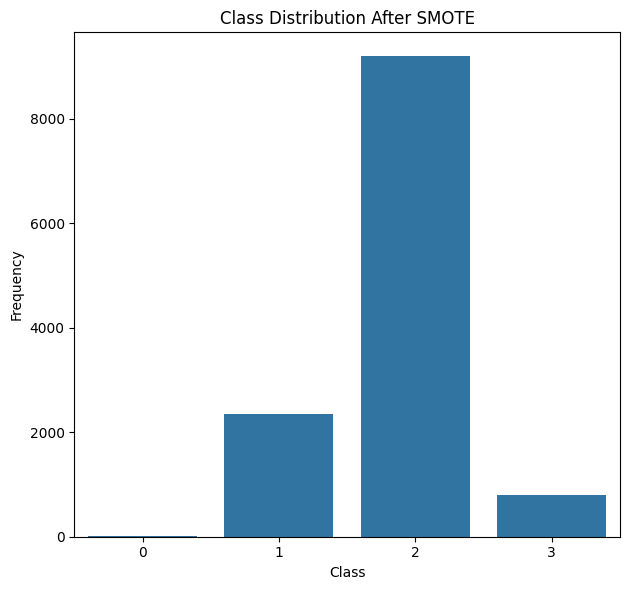

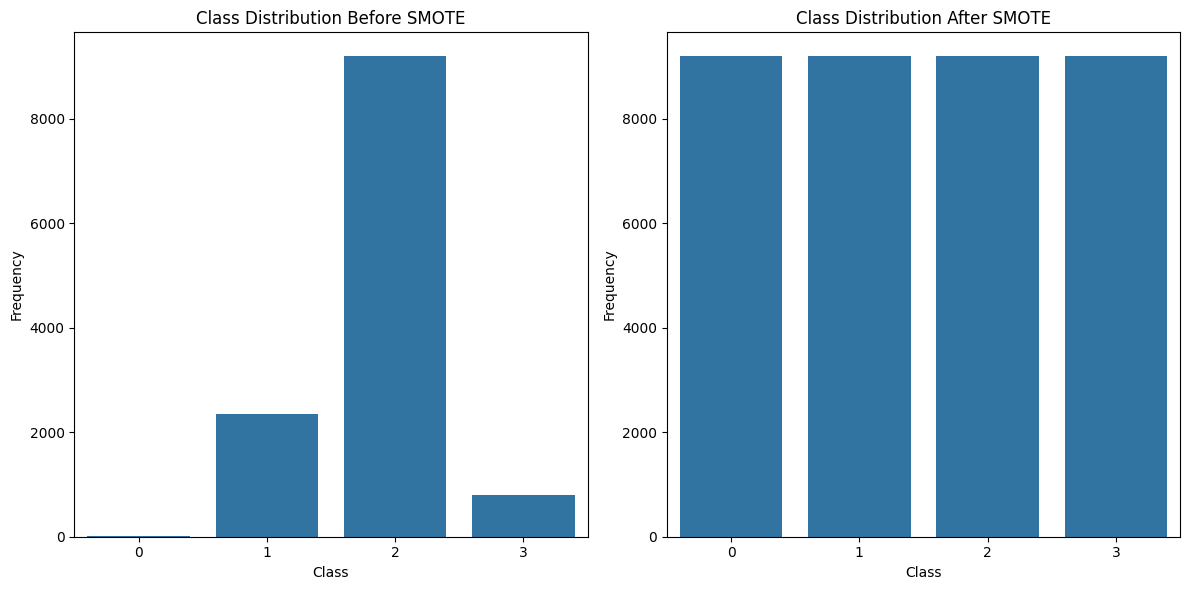

c:\Users\sagor\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
736/736 ━━━━━━━━━━━━━━━━━━━━ 51s 63ms/step - accuracy: 0.7028 - loss: 4.6589 - val_accuracy: 0.7373 - val_loss: 1.9908
Epoch 2/50
736/736 ━━━━━━━━━━━━━━━━━━━━ 44s 59ms/step - accuracy: 0.8012 - loss: 2.1211 - val_accuracy: 0.8253 - val_loss: 1.8569
Epoch 3/50
736/736 ━━━━━━━━━━━━━━━━━━━━ 44s 59ms/step - accuracy: 0.8240 - loss: 1.9300 - val_accuracy: 0.8438 - val_loss: 2.0839
Epoch 4/50
736/736 ━━━━━━━━━━━━━━━━━━━━ 44s 59ms/step - accuracy: 0.8362 - loss: 2.1205 - val_accuracy: 0.9174 - val_loss: 1.9516
Epoch 5/50
736/736 ━━━━━━━━━━━━━━━━━━━━ 44s 60ms/step - accuracy: 0.8575 - loss: 1.9272 - val_accuracy: 0.9271 - val_loss: 1.5639
Epoch 6/50
736/736 ━━━━━━━━━━━━━━━━━━━━ 44s 59ms/step - accuracy: 0.8601 - loss: 1.7718 - val_accuracy: 0.8613 - val_loss: 1.7273
Epoch 7/50
736/736 ━━━━━━━━━━━━━━━━━━━━ 46s 63ms/step - accuracy: 0.8627 - loss: 1.6573 - val_accuracy: 0.9336 - val_loss: 1.5632
Epoch 8/50
736/736 ━━━━━━━━━━━━━━━━━━━━ 45s 61ms/step - accuracy: 0.8698 - loss: 1.5462 - 

In [26]:
# Load and merge the datasets
merged_data = load_and_merge_data(file_paths)

# Extract high-correlation features (optional debugging)
high_corr_features_covid = extract_high_correlation_features(merged_data, target_column="COVID-19_conditions", threshold=0.8)
print("Highly correlated features with COVID-19_conditions:", high_corr_features_covid)

high_corr_features_deceased = extract_high_correlation_features(merged_data, target_column="DECEASED_patients", threshold=0.8)
print("Highly correlated features with DECEASED_patients:", high_corr_features_deceased)

# Train and prepare the model
model, X_test, y_test, processed_data, labels = prepare_and_train_model(merged_data)

230/230 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9516 - loss: 0.7732
Test Loss: 0.7754974961280823, Test Accuracy: 0.9528276324272156
230/230 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1816
           1       0.98      0.97      0.98      1822
           2       0.91      0.91      0.91      1863
           3       0.92      0.93      0.93      1855

    accuracy                           0.95      7356
   macro avg       0.95      0.95      0.95      7356
weighted avg       0.95      0.95      0.95      7356



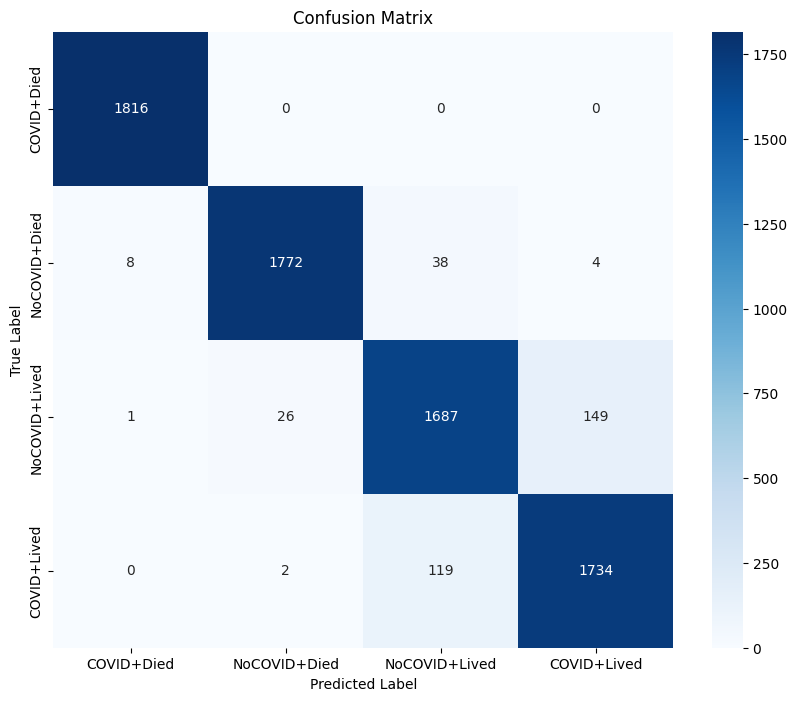

78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8991 - loss: 0.8577
Original Test Loss: 0.8747003078460693, Original Test Accuracy: 0.8915418982505798
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Original Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.33      1.00      0.50         2
           1       0.93      0.95      0.94       459
           2       0.96      0.90      0.93      1836
           3       0.43      0.67      0.52       174

    accuracy                           0.89      2471
   macro avg       0.66      0.88      0.72      2471
weighted avg       0.91      0.89      0.90      2471



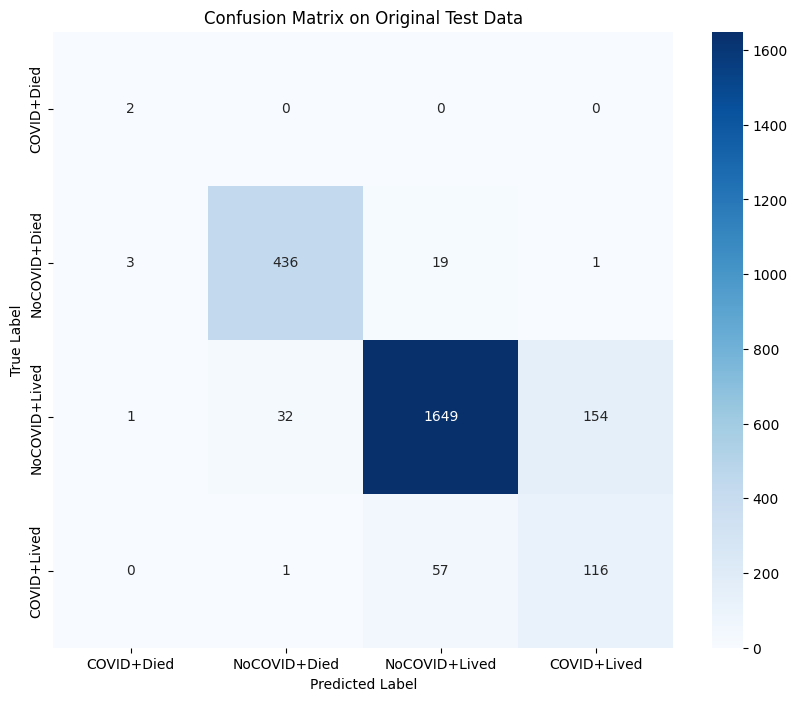

Feature Importance (from first layer weights):
MARITAL_patients: 0.07918629795312881
DESCRIPTION_10 ML Pamidronate Disodium 3 MG/ML Injection_medications: 0.05397285893559456
DESCRIPTION_1 ML Enoxaparin sodium 150 MG/ML Prefilled Syringe_medications: 0.053672078996896744
DESCRIPTION_1 ML DOCEtaxel 20 MG/ML Injection_medications: 0.05366888269782066
DESCRIPTION_10 ML Fentanyl 0.05 MG/ML Injection_medications: 0.05275239422917366
DESCRIPTION_100 ML zoledronic acid 0.04 MG/ML Injection_medications: 0.05222861096262932
DESCRIPTION_1 ML Epinephrine 1 MG/ML Injection_medications: 0.04939165711402893
DESCRIPTION_1 ML Vasopressin (USP) 20 UNT/ML Injection_medications: 0.04534606635570526
DESCRIPTION_1 ML heparin sodium  porcine 5000 UNT/ML Injection_medications: 0.03914901614189148
DESCRIPTION_10 ML Furosemide 10 MG/ML Injection_medications: 0.03627293184399605
Top Features Correlated with Labels:
SARS-CoV-2 RNA Pnl Resp NAA+probe_observations: 0.4893819912709172
Left ventricular Ejection frac

c:\Users\sagor\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\sagor\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [27]:
# Evaluate the model
evaluate_model(model, X_test, y_test)

# Evaluate on the original test data
evaluate_on_original_test_data(model, processed_data, labels)

# Feature importance from weights
feature_names = processed_data.columns.tolist()
sorted_importance = get_feature_importance_from_weights(model, feature_names)

# Feature-label correlation
sorted_correlation = get_feature_label_correlation(processed_data, labels)